# Neural Network Force-Free magnetic field extrapolation - NF2
<img src="https://github.com/RobertJaro/NF2/blob/main/images/logo.jpg?raw=true" width="150" height="150">

This notebook uses NF2 to download and extrapolate vector magnetograms from SDO/HMI. Active regions and dates can be selected below. This version uses a pre-trained simulation as meta-state to achieve faster results.


GitHub Page: https://github.com/RobertJaro/NF2


**Use**: A python notebook consists of code cells and embedded text descriptions. If you are using Google Colab all computations and installations are performed online, using free resources. You can execute the notebook cell-by-cell (hit `shift`+`return`), or run the full notebook by selecting `Runtime` --> `Run all` from the menu. Use the forms below to select the active region, date, and training parameters. For regular use you can keep the default training parameters.

## Installation and Imports

In [ ]:
!pip install git+https://github.com/RobertJaro/NF2.git

In [2]:
# general imports
import glob
import os
from datetime import datetime
from dateutil.parser import parse
import shutil

# download
import drms
from urllib import request

# data processing
import numpy as np
from astropy.nddata import block_reduce
from sunpy.map import Map

# deep learning
import torch

# NF2
from nf2.train.trainer import NF2Trainer
from nf2.data.download import download_HARP, find_HARP, donwload_ds
from nf2.train.metric import *
from nf2.evaluation.unpack import load_cube
from nf2.evaluation.energy import get_free_mag_energy

# visualization
from matplotlib import pyplot as plt

# Single extrapolation

## Data download

We start by downloading a vector magnetogram of SDO/HMI. Use the forms below to set your email, and specify the active region that you are interested in (SHARP + date).

Downloading data requires an active registration at JSOC. http://jsoc.stanford.edu/ajax/register_email.html (free of charge)

In [3]:
#@title Download Credentials
jsoc_email = 'robert.jarolim@uni-graz.at' #@param {type:"string"}

In [4]:
client = drms.Client(email=jsoc_email, verbose=True)

If you are looking for a NOAA active region, you can use the function below to search for the corrsponding HARP number.

In [5]:
# Find SHARP number for given NOAA
noaa_nums = [12673]
start_time = datetime(2017, 9, 6, 8)
find_HARP(start_time, noaa_nums, client)

7115

In [6]:
#@title Active Region
sharp_nr = 7115 #@param {type:"number"}
year = 2017 #@param {type:"integer"}
month = 9 #@param {type:"integer"}
day = 6 #@param {type:"integer"}
hour = 8 #@param {type:"integer"}
minute = 36 #@param {type:"number"}

date = datetime(year, month, day, hour, minute)

download_dir = 'AR_7115' #@param {type:"string"}

In [7]:
download_HARP(sharp_nr, date, download_dir, client)

Export request pending. [id=JSOC_20220519_591, status=2]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20220519_591, status=1]
Waiting for 5 seconds...
    record: None
  filename: JSOC_20220519_591.tar
  -> AR_7115/JSOC_20220519_591.tar


For training new extrapolations it is time efficient to start from a pre-trained state. We use the weights of a different extrapolation to initialize our model. Although trained for a different active region, this model already fullfills the divergence- and force-free constrains, which enables a faster convergence. To start your training from scratch set `meta_path = None`. The forms below can be kept at their default value (you still need to run the cells).

In [8]:
request.urlretrieve('http://kanzelhohe.uni-graz.at/nf2/meta.pt', 'meta.pt')

('meta.pt', <http.client.HTTPMessage at 0x7fdf1ce02450>)

In [9]:
#@title Meta state
meta_path = 'meta.pt'#@param {type:"raw"}


In [10]:
#@title Paths
base_path = None #@param {type:"string"}
base_path = 'ar_%d_%s' % (sharp_nr, date.isoformat('T')) if base_path is None else base_path
data_path = None #@param {type:"string"}
data_path = download_dir if data_path is None else data_path

In [11]:
#@title Data Parameters
bin = 2 #@param {type:"integer"}
spatial_norm = 160  #@param {type:"integer"}
height = 160  #@param {type:"integer"}
b_norm = 2500  #@param {type:"number"}
d_slice =  None#@param {type:"raw"}

In [12]:
#@title Model Parameters
dim = 256 #@param {type:"number"}

In [13]:
#@title Training Parameters
lambda_div = 0.01 #@param {type:"number"}
lambda_ff = 0.01 #@param {type:"number"}
# use 300 for meta training and 800 when trained from scratch
epochs = 200 #@param {type:"number"}
epochs = int(epochs)
# decay not used if meta set
decay_epochs = 500 #@param {type:"number"}
decay_epochs = int(decay_epochs)
batch_size = 1e4 #@param {type:"number"}
batch_size = int(batch_size)
n_samples_epoch = 1e6 #@param {type:"number"}
n_samples_epoch = int(n_samples_epoch)
log_interval = 10 #@param {type:"integer"}
validation_interval = 100 #@param {type:"integer"}
potential = True #@param {type:"boolean"}



Before we start the extrapolation we need to process the downloaded data. The model requires the vector magnetogram and the corresponding error map. If specified, the sub-region is extracted and the data is binned (default bin 2).

In [14]:
if isinstance(data_path, str):
    hmi_p = sorted(glob.glob(os.path.join(data_path, '*Bp.fits')))[0]  # x
    hmi_t = sorted(glob.glob(os.path.join(data_path, '*Bt.fits')))[0]  # y
    hmi_r = sorted(glob.glob(os.path.join(data_path, '*Br.fits')))[0]  # z
    err_p = sorted(glob.glob(os.path.join(data_path, '*Bp_err.fits')))[0]  # x
    err_t = sorted(glob.glob(os.path.join(data_path, '*Bt_err.fits')))[0]  # y
    err_r = sorted(glob.glob(os.path.join(data_path, '*Br_err.fits')))[0]  # z
else:
    hmi_p, err_p, hmi_r, err_r, hmi_t, err_t = data_path

hmi_cube = np.stack([Map(hmi_p).data, -Map(hmi_t).data, Map(hmi_r).data]).transpose()
error_cube = np.stack([Map(err_p).data, Map(err_t).data, Map(err_r).data]).transpose()
if d_slice is not None:
    hmi_cube = hmi_cube[d_slice[0]:d_slice[1], d_slice[2]:d_slice[3]]
    error_cube = error_cube[d_slice[0]:d_slice[1], d_slice[2]:d_slice[3]]

In [15]:
# bin data
if bin > 1:
    hmi_cube = block_reduce(hmi_cube, (bin, bin, 1), np.mean)
    error_cube = block_reduce(error_cube, (bin, bin, 1), np.mean)

## Training / Extrapolation

The trainer initializes the model and computest the initial potential field boundary.

In [16]:
trainer = NF2Trainer(base_path, hmi_cube, error_cube, height, spatial_norm, b_norm, dim,
                     potential_boundary=potential, lambda_div=lambda_div, lambda_ff=lambda_ff,
                     decay_epochs=decay_epochs, num_workers=4, meta_path=meta_path)

Configuration:
dim: 256, lambda_div: 0.010000, lambda_ff: 0.010000, potential: True, decay_epochs: 500
Using device: cuda (gpus 1) ['Tesla T4']
100%|██████████| 223/223 [00:28<00:00,  7.81it/s]
Cube shape: [344, 224, 160] (x, y, z)
Loaded meta state: meta.pt


In the menu on the left you can find the directory with logged results. After the initialization you should find the target magnetogram for training. For the default setting this image is generated.

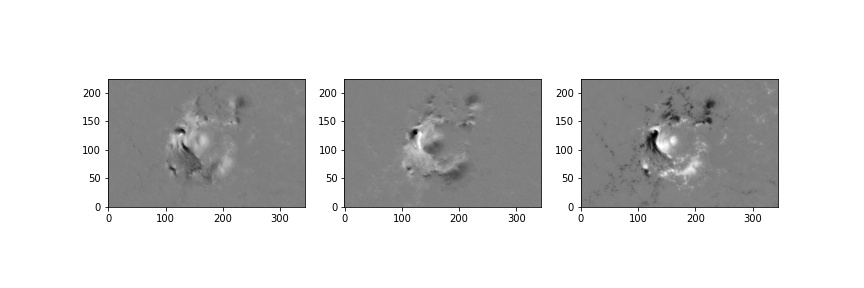

Now we can start the training. This requires about 800-1000 epochs for the training from scratch and 100-300 epochs if you start from the meta state. Every 100 epochs the total divergence and sigma angle are logged, which can be used to estimate for the model performance. The model is saved in the same interval. You can always train longer if you still note an improvement.

**Note:** During training make sure to download 'checkpoint.pt', in case the Colab runtime interrupts. If this file is present in the directory, the training will continued from the last save state. The logged images show horizontal slices through the volume, scaled by their maximum and minimum value.

In [ ]:
trainer.train(epochs, batch_size, n_samples_epoch, log_interval, validation_interval)

## Evaluation

If you want to skip the training you can use the line below to download the example solution.

In [ ]:
# request.urlretrieve('http://kanzelhohe.uni-graz.at/nf2/example_7115.nf2', 'example_7115.nf2')
# shutil.move('example_7115.nf2', os.path.join(base_path, 'extrapolation_result.nf2'))

It is important that the resutls are checked after the extrapolation is finished. The NF2 package provides metrics that can be used to estimate the quality. Both the divergence and the angle between the currents and magnetic field should be small. (ideally mean divergence `<0.1` and sigma `<10` degree; the exact values depend on the selected active region and lambda weights)

From the save file we can load the full simulation volume.

In [18]:
final_model_path = os.path.join(base_path, 'extrapolation_result.nf2')
b = load_cube(final_model_path, progress=True)

100%|██████████| 12329/12329 [00:11<00:00, 1063.73it/s]


DIVERGENCE: 0.3507; SIGMA 17.8538


The loaded mesh can be used to compute the divergence and the sigma angle.

In [ ]:
div = np.abs(divergence(b)).mean()
sigma = weighted_sigma(b)

print('DIVERGENCE: %.04f; SIGMA %.04f' % (div, sigma))

We can also compute maps of integrated current density.

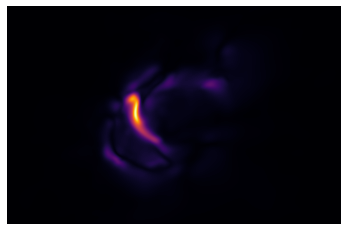

In [19]:
j = curl(b)
plt.figure(figsize=(8,4))
plt.imshow(vector_norm(j).sum(2).transpose(), origin='lower', cmap='inferno')
plt.axis('off')
plt.show()

By computing the potential field we can estimate the free magnetic energy, and visualize the result as integrated map. Here, we only consider the first 64 grid cells in height for faster computation.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 4932/4932 [02:59<00:00, 27.44it/s]


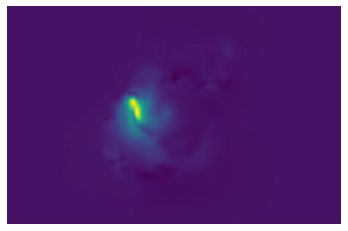

In [20]:
free_me = get_free_mag_energy(b[:, :, :64])
plt.figure(figsize=(8,4))
plt.imshow(free_me.sum(2).transpose(), origin='lower')
plt.axis('off')
plt.show()

## Export

VTK files can be used to visualize the extrapolation results (e.g., Paraview). We use `tvtk` for converting the files.
The NF2 results require little storage (about 2 MB). It is faster to download the NF2 file and convert it on your local environment using the CPU resources.

The code below can be used to convert files in Colab.

In [ ]:
!pip install vtk==9.0.1
!pip install mayavi

In [22]:
from nf2.evaluation.unpack import load_cube
from nf2.evaluation.vtk import save_vtk

In [23]:
model_path = base_path + '/extrapolation_result.nf2'
vtk_path = base_path + '/extrapolation_result.vtk'

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
b = load_cube(model_path, device, progress=True)
save_vtk(b, vtk_path, 'B')

100%|██████████| 12329/12329 [00:18<00:00, 649.41it/s] 
Could not load pyface.toolkits plugin 'qt4' from 'pyface.ui.qt4.init'
Could not load pyface.toolkits plugin 'wx' from 'pyface.ui.wx.init'
Could not load pyface.toolkits plugin 'qt' from 'pyface.ui.qt4.init'


# Series of extrapolations

Starting from our previous extrapolation, we now simulate the temporal evolution. For this we adapt the model sequentially by changing the boundary condition and re-training the model. This allows us to converge within a few epochs per time step.

We start by downloading the data. Fill the form below to select your time range. Note that we use the same start point and sharp as in the previous extrapolation (i.e., we require an initial extrapolation).

## Data download

In [24]:
#@title Paths
series_base_path = None #@param {type:"string"}
series_base_path = 'ar_series_%d_%s' % (sharp_nr, date.isoformat('T')) if series_base_path is None else series_base_path

In [25]:
#@title Duration

duration = '4h' # @param {type:"string"}
series_download_dir = 'AR_7115_series' #@param {type:"string"}

For downloading the series we use DRMS.

In [26]:
os.makedirs(series_download_dir, exist_ok=True)
ds = 'hmi.sharp_cea_720s[%d][%s/%s]{Br, Bp, Bt, Br_err, Bp_err, Bt_err}' % \
     (sharp_nr, date.isoformat('_', timespec='seconds'), duration)
donwload_ds(ds, series_download_dir, client)

Export request pending. [id=JSOC_20220519_673, status=2]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20220519_673, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20220519_673, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20220519_673, status=1]
Waiting for 5 seconds...
    record: None
  filename: JSOC_20220519_673.tar
  -> AR_7115_series/JSOC_20220519_673.tar


## Training

In [27]:
# settings are equivalent to 10 epochs of the previous configuration
series_epochs = 1 # @param {type:"integer"}
series_n_samples_epoch = 1e7 # @param {type:"number"}
series_batch_size = 1e4 #@param {type:"number"}
series_batch_size = int(batch_size)
series_n_samples_epoch = int(series_n_samples_epoch)
series_validation_interval = 100 # @param {type:"integer"}

If you want to start from a different state (e.g., other active region), you can specify your extrapolation file below (checkpoint.pt or extrapolation_result.nf2).

In [ ]:
# load the inital model from our previous training
new_meta_path = os.path.join(base_path, 'checkpoint.pt') # @param {type:"raw"}

For the series training we perform for each observation the data pre-processing and perform the extrapolation with the state of the previous iteration.

In [28]:
# scan all data files
hmi_p_files = sorted(glob.glob(os.path.join(series_download_dir, '*Bp.fits')))  # x
hmi_t_files = sorted(glob.glob(os.path.join(series_download_dir, '*Bt.fits')))  # y
hmi_r_files = sorted(glob.glob(os.path.join(series_download_dir, '*Br.fits')))  # z
err_p_files = sorted(glob.glob(os.path.join(series_download_dir, '*Bp_err.fits')))  # x
err_t_files = sorted(glob.glob(os.path.join(series_download_dir, '*Bt_err.fits')))  # y
err_r_files = sorted(glob.glob(os.path.join(series_download_dir, '*Br_err.fits')))  # z

for hmi_p, hmi_t, hmi_r, err_p, err_t, err_r in zip(hmi_p_files, hmi_t_files, hmi_r_files,
                                                    err_p_files, err_t_files, err_r_files):
    file_id = os.path.basename(hmi_p).split('.')[3]
    bp = os.path.join(series_base_path, file_id)

    # check if finished
    final_model_path = os.path.join(bp, 'final.pt')
    if os.path.exists(final_model_path):
        new_meta_path = final_model_path
        continue
    
    # data pre-processing; same as for the single extrapolation
    hmi_cube = np.stack([Map(hmi_p).data, -Map(hmi_t).data, Map(hmi_r).data]).transpose()
    error_cube = np.stack([Map(err_p).data, Map(err_t).data, Map(err_r).data]).transpose()
    if d_slice is not None:
      hmi_cube = hmi_cube[d_slice[0]:d_slice[1], d_slice[2]:d_slice[3]]
      error_cube = error_cube[d_slice[0]:d_slice[1], d_slice[2]:d_slice[3]]
    if bin > 1:
      hmi_cube = block_reduce(hmi_cube, (bin, bin, 1), np.mean)
      error_cube = block_reduce(error_cube, (bin, bin, 1), np.mean)
    trainer = NF2Trainer(bp, hmi_cube, error_cube, height, spatial_norm, b_norm, dim,
                     lambda_div=lambda_div, lambda_ff=lambda_ff,
                     meta_path=new_meta_path, potential_boundary=potential, num_workers=4)
    trainer.train(series_epochs, series_batch_size, series_n_samples_epoch, 1, 100) # ignore validation for series training
    new_meta_path = final_model_path

Configuration:
dim: 256, lambda_div: 0.010000, lambda_ff: 0.010000, potential: True, decay_epochs: None
Using device: cuda (gpus 1) ['Tesla T4']
100%|██████████| 223/223 [00:28<00:00,  7.76it/s]
Cube shape: [344, 224, 160] (x, y, z)
Loaded meta state: ar_7115_2017-09-06T08:36:00/checkpoint.pt
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 1000/1000 [03:55<00:00,  4.24it/s]
[Epoch 00001/00001] [B-Field: 0.00071691; Div: 0.00406425; For: 0.00858516] [0:03:55.766165]
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr

## Evaluation

With the extrapolated series we can now track the change in magnetic energy, free magnetic energy, and identify the position of flare occurence.

Note that we only compute the free magnetic energy for the first 20 Mm.

In [29]:
nf2_paths = sorted(glob.glob(os.path.join(series_base_path, '**', 'extrapolation_result.nf2')))
Mm_per_pix = 360e-3
z_pixels = int(np.ceil(20 / (2 * Mm_per_pix)))  # 20 Mm --> pixels; bin2

# save results as npy files
evaluation_path = os.path.join(series_base_path, 'evaluation')
os.makedirs(evaluation_path, exist_ok=True)
free_energy_files = []
for path in nf2_paths:
  b = load_cube(path, progress=True, z=z_pixels)
  free_me = get_free_mag_energy(b)
  f = os.path.join(evaluation_path, '%s.npy' % path.split('/')[-2])
  np.save(f, free_me)
  free_energy_files += [f]

series_dates = [datetime.strptime(os.path.basename(f), '%Y%m%d_%H%M%S_TAI.npy') for f in free_energy_files]

100%|██████████| 2158/2158 [00:02<00:00, 984.55it/s] 
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 2158/2158 [01:16<00:00, 28.17it/s]


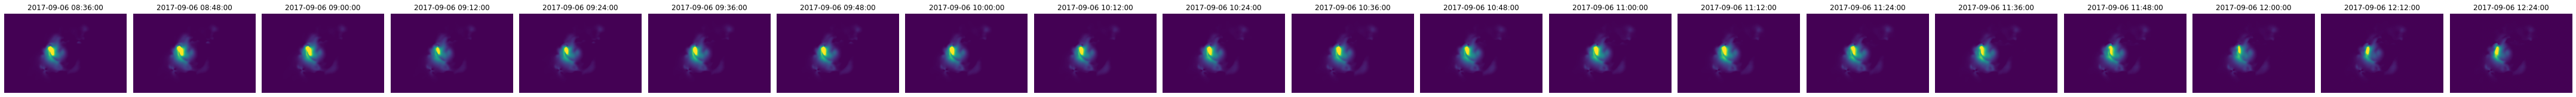

In [40]:
# plot the free magnetic evolution
fig, axs = plt.subplots(1, len(free_energy_files), figsize=(len(free_energy_files) * 3, 6))
for f, ax, d in zip(free_energy_files, axs, series_dates):
  free_me = np.load(f)
  ax.imshow(free_me.sum(2).transpose(), vmin=0, vmax=1e6, origin='lower')
  ax.set_title(d.isoformat(' '))
  ax.set_axis_off()

plt.tight_layout()
plt.show()

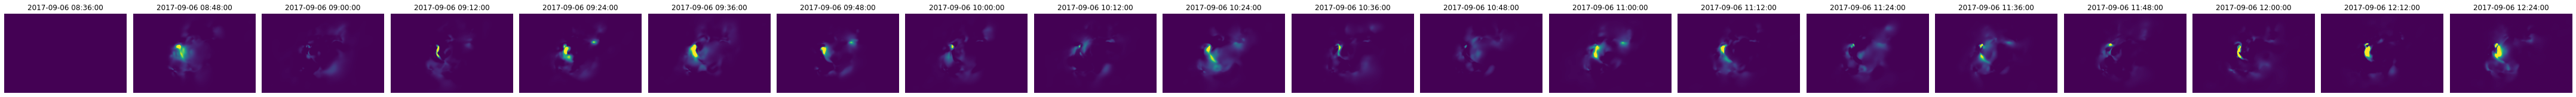

In [39]:
# plot the energy depletion
prev_me = None
fig, axs = plt.subplots(1, len(free_energy_files), figsize=((len(free_energy_files)) * 3, 6))
for f, ax, d in zip(free_energy_files, axs, series_dates):
  free_me = np.load(f)
  if prev_me is None:
    prev_me = free_me
  ax.imshow(np.clip(free_me - prev_me, 0, None).sum(2).transpose(), vmin=0, vmax=1e5, origin='lower')
  ax.set_title(d.isoformat(' '))
  ax.set_axis_off()
  prev_me = free_me

plt.tight_layout()
plt.show()

Registered flares in this sequence (2017-09-06 08:36 - 12:24): X2.2 - 08:57; C5.4 - 10:13; X9.3 - 11:53

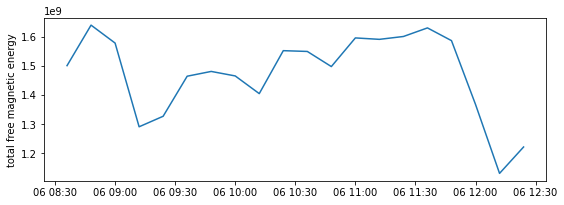

In [32]:
# plot the integrated free magnetic energy
plt.figure(figsize=(9, 3))
plt.plot(series_dates, [np.load(f).sum() for f in free_energy_files])
plt.ylabel('total free magnetic energy')
plt.show()